In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from mpl_toolkits import mplot3d

from math import sqrt
SPINE_COLOR = 'gray'
import numpy as np
import matplotlib.pyplot as plt
plt.get_cmap('gnuplot2')

%matplotlib inline
# Based on: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

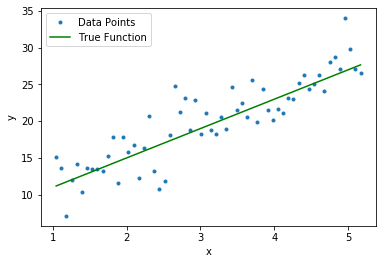

In [116]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducability
y = 4*x + 7 + np.random.normal(0,3,len(x))
y_true = 4*x + 7
max_deg = 20
data_x = [x**(i+1) for i in range(max_deg)] + [y]
data_c = ['x'] + ['x_{}'.format(i+1) for i in range(1,max_deg)] + ['y']
data = pd.DataFrame(np.column_stack(data_x),columns=data_c)
data["ones"] = 1
plt.plot(data['x'],data['y'],'.', label='Data Points')
plt.plot(data['x'], y_true,'g', label='True Function')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig('lin_1.pdf', transparent=True, bbox_inches="tight")

In [20]:
from sklearn.linear_model import LinearRegression
coef_list = []
for i,deg in enumerate([1,3,6,11]):
    predictors = ['ones','x']
    if deg >= 2:
        predictors.extend(['x_%d'%i for i in range(2,deg+1)])  

    regressor = LinearRegression(normalize=False, fit_intercept=False)  
    regressor.fit(data[predictors],data['y'])
    y_pred = regressor.predict(data[predictors])
    coef_list.append(abs(max(regressor.coef_, key=abs)))

    plt.scatter(data['x'],data['y'], label='Train')
    plt.plot(data['x'], y_pred,'k', label='Prediction')
    plt.plot(data['x'], y_true,'g.', label='True Function')
    plt.legend() 
    plt.title(f"Degree: {deg} | Max Coeff: {max(regressor.coef_, key=abs):.2f}")
    plt.savefig('lin_plot_{}.pdf'.format(deg), transparent=True, bbox_inches="tight")
    plt.clf()

<Figure size 432x288 with 0 Axes>

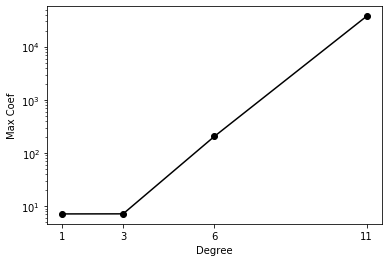

In [21]:
plt.semilogy([1,3,6,11],coef_list,'o-k')
plt.xticks([1,3,6,11])
plt.xlabel('Degree')
plt.ylabel('Max Coef')
plt.savefig('lin_plot_coef.pdf', transparent=True, bbox_inches="tight")

In [22]:
def cost(theta_0, theta_1, x, y):
    s = 0
    for i in range(len(x)):
        y_i_hat = x[i]*theta_1 + theta_0
        s += (y[i]-y_i_hat)**2
    return s/len(x)

x_grid, y_grid = np.mgrid[-4:15:.2, -4:15:.2]

cost_matrix = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        cost_matrix[i, j] = cost(x_grid[i, j], y_grid[i, j], data['x'], data['y'])

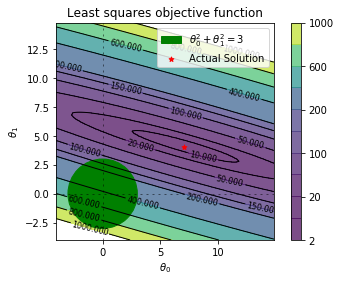

In [23]:
from matplotlib.patches import Circle

levels = np.sort(np.array([2,10,20,50,100,150,200,400,600,800,1000]))

plt.contourf(x_grid, y_grid, cost_matrix, levels,alpha=.7)
plt.colorbar()
plt.axhline(0, color='black', alpha=.5, dashes=[2, 4],linewidth=1)
plt.axvline(0, color='black', alpha=0.5, dashes=[2, 4],linewidth=1)

CS = plt.contour(x_grid, y_grid, cost_matrix, levels, linewidths=1,colors='black')
plt.clabel(CS, inline=1, fontsize=8)
plt.title("Least squares objective function")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
p1 = Circle((0, 0), 3, color='g', label=r'$\theta_0^2+\theta_1^2=3$')
plt.scatter([7], [4],marker='*', color='r',s=25,label='Actual Solution')
plt.gca().add_patch(p1)
plt.legend()
plt.gca().set_aspect('equal')

plt.savefig('ridge_base_contour.pdf', transparent=True, bbox_inches="tight")
plt.show()

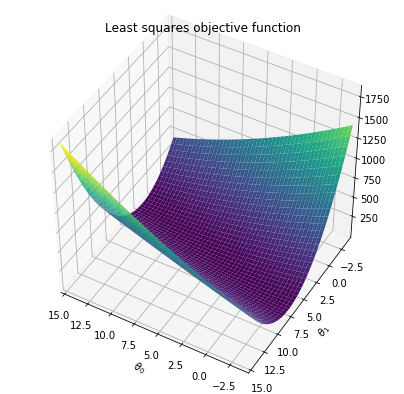

In [45]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, y_grid, cost_matrix,cmap='viridis', edgecolor='none')
ax.set_title('Least squares objective function');
ax.set_xlabel(r"$\theta_0$")
ax.set_ylabel(r"$\theta_1$")
ax.set_xlim([-4,15])
ax.set_ylim([-4,15])

u = np.linspace(0, np.pi, 30)
v = np.linspace(0, 2 * np.pi, 30)

# x = np.outer(500*np.sin(u), np.sin(v))
# y = np.outer(500*np.sin(u), np.cos(v))
# z = np.outer(500*np.cos(u), np.ones_like(v))
# ax.plot_wireframe(x, y, z)

ax.view_init(45, 120)
plt.savefig('ridge_base_surface.pdf', transparent=True, bbox_inches="tight")

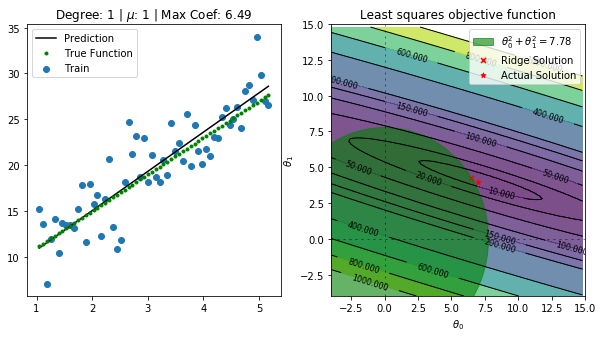

<Figure size 432x288 with 0 Axes>

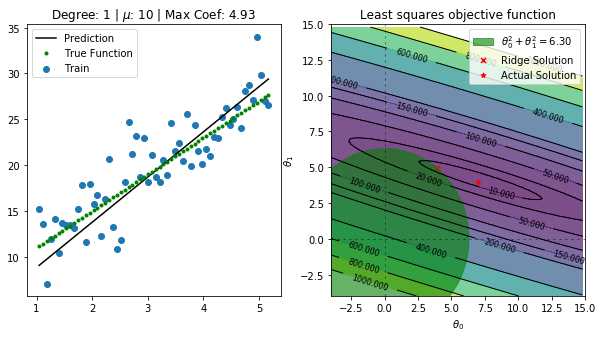

<Figure size 432x288 with 0 Axes>

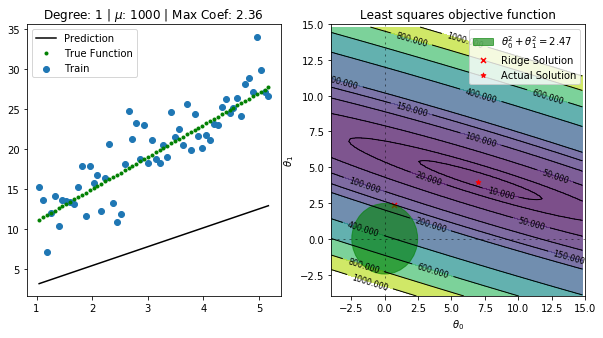

<Figure size 432x288 with 0 Axes>

In [110]:
from sklearn.linear_model import Ridge

for alpha in [1, 10, 1000]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    deg = 1
    predictors = ['ones','x']
    if deg >= 2:
        predictors.extend(['x_%d'%i for i in range(2,deg+1)])  

    regressor = Ridge(alpha=alpha,normalize=True, fit_intercept=False)
    regressor.fit(data[predictors],data['y'])
    y_pred = regressor.predict(data[predictors])

    # Plot
    ax[0].scatter(data['x'],data['y'], label='Train')
    ax[0].plot(data['x'], y_pred,'k', label='Prediction')
    ax[0].plot(data['x'], y_true,'g.', label='True Function')
    ax[0].legend() 
    ax[0].set_title(f"Degree: {deg} | $\mu$: {alpha} | Max Coef: {max(regressor.coef_, key=abs):.2f}")

    # Circle
    p1 = Circle((0, 0), np.sqrt(regressor.coef_.T@regressor.coef_), alpha=0.6, color='g', label=r'$\theta_0^2+\theta_1^2={:.2f}$'.format(np.sqrt(regressor.coef_.T@regressor.coef_)))
    ax[1].add_patch(p1)

    # Contour
    levels = np.sort(np.array([2,10,20,50,100,150,200,400,600,800,1000]))
    ax[1].contourf(x_grid, y_grid, cost_matrix, levels,alpha=.7)
    #ax[1].colorbar()
    ax[1].axhline(0, color='black', alpha=.5, dashes=[2, 4],linewidth=1)
    ax[1].axvline(0, color='black', alpha=0.5, dashes=[2, 4],linewidth=1)

    CS = plt.contour(x_grid, y_grid, cost_matrix, levels, linewidths=1,colors='black')
    ax[1].clabel(CS, inline=1, fontsize=8)
    ax[1].set_title("Least squares objective function")
    ax[1].set_xlabel(r"$\theta_0$")
    ax[1].set_ylabel(r"$\theta_1$")
    ax[1].scatter(regressor.coef_[0],regressor.coef_[1] ,marker='x', color='r',s=25,label='Ridge Solution')
    ax[1].scatter([7], [4],marker='*', color='r',s=25,label='Actual Solution')
    ax[1].set_xlim([-4,15])
    ax[1].set_ylim([-4,15])
    ax[1].legend()

    plt.savefig('ridge_{}.pdf'.format(alpha), transparent=True, bbox_inches="tight")
    plt.show()
    plt.clf()

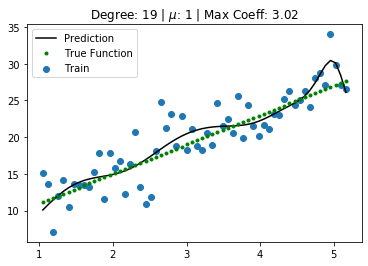

/home/shreyas/miniconda3/envs/grader/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.77719e-18): result may not be accurate.
  overwrite_a=True).T


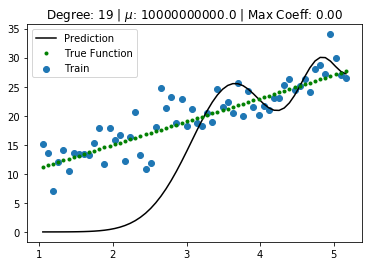

<Figure size 432x288 with 0 Axes>

In [118]:
from sklearn.linear_model import Ridge

for i,deg in enumerate([19]):
    predictors = ['ones', 'x']
    if deg >= 2:
        predictors.extend(['x_%d'%i for i in range(2,deg+1)])  

    for i,alpha in enumerate([1, 1e10]):
        regressor = Ridge(alpha=alpha,normalize=False, fit_intercept=False)
        regressor.fit(data[predictors],data['y'])
        y_pred = regressor.predict(data[predictors])
        plt.scatter(data['x'],data['y'], label='Train')
        plt.plot(data['x'], y_pred,'k', label='Prediction')
        plt.plot(data['x'], y_true,'g.', label='True Function')
        plt.legend() 
        plt.title(f"Degree: {deg} | $\mu$: {alpha} | Max Coeff: {max(regressor.coef_, key=abs):.2f}")
        plt.savefig('ridge_{}_{}.pdf'.format(alpha, deg), transparent=True, bbox_inches="tight")
        plt.show()
        plt.clf()

In [94]:
# from sklearn.linear_model import Ridge

# for i,deg in enumerate([2,4,8,16]):
#   predictors = ['x']
#   if deg >= 2:
#     predictors.extend(['x_%d'%i for i in range(2,deg+1)])  
#   fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20, 4))

#   for i,alpha in enumerate([1e-15,1e-4,1,20]):
#     regressor = Ridge(alpha=alpha,normalize=True)
#     regressor.fit(data[predictors],data['y'])
#     y_pred = regressor.predict(data[predictors])
#     ax[i].scatter(data['x'],data['y'], label='Train')
#     ax[i].plot(data['x'], y_pred,'k', label='Prediction')
#     ax[i].plot(data['x'], y_true,'g.', label='True Function')
#     ax[i].legend() 
#     ax[i].set_title(f"Degree: {deg} | Alpha: {alpha} | Max Coeff: {max(regressor.coef_, key=abs):.2f}")

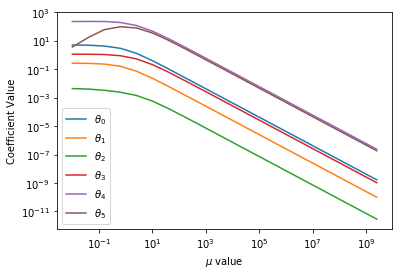

In [113]:
import pandas as pd

data = pd.read_excel("data.xlsx")
cols = data.columns
alph_list = np.logspace(-2,10,num=20, endpoint=False)
coef_list = []

for i,alpha in enumerate(alph_list):
    regressor = Ridge(alpha=alpha,normalize=True)
    regressor.fit(data[cols[1:-1]],data[cols[-1]])
    coef_list.append(regressor.coef_)

coef_list = np.abs(np.array(coef_list).T)
for i in range(len(cols[1:-1])):
    plt.loglog(alph_list, coef_list[i] , label=r"$\theta_{}$".format(i))
plt.xlabel('$\mu$ value')
plt.ylabel('Coefficient Value')
plt.legend() 
plt.savefig('rid_reg.pdf', transparent=True, bbox_inches="tight")
# plt.set_title(f"Degree: {deg} | Alpha: {alpha} | Max Coeff: {max(regressor.coef_, key=abs):.2f}")

### Question

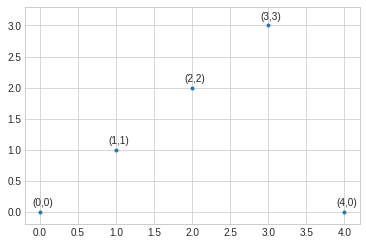

In [123]:
plt.style.use('seaborn-whitegrid')

x = [0,1,2,3,4]
y = [0,1,2,3,0]
y_1 = [(2-i/5) for i in x]
y_2 = [(0.5+0.4*i) for i in x]
plt.ylim(-0.2,3.3)
plt.plot(x,y,'.')
for i in range(len(x)):
    plt.text(x[i]-0.1, y[i]+0.1, "({},{})".format(x[i], y[i]))
#plt.plot(x,y_1, label="unreg")
#plt.plot(x,y_2, label="reg")
#plt.legend()
plt.savefig('temp.pdf', transparent=True)